<a href="https://colab.research.google.com/github/isa-ulisboa/greends-pml/blob/main/notebooks/T9b_MNIST_CNNs_pipeline_save_load_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we present a total pipeline for the MNIST data set, using a custom convolutional neural network `simple_cnn`.

We discuss how to save and load the trained model.

In [22]:
!pip install torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

### Change device: run training on GPU

Training involves many large matrix computations. In general, this is done faster if it is parellelized over multiple cores. One can determine which device, either `cuda` (for GPU) or `cpu`, is used for training. Both model and data must be moved to the right device.

However, in Colab this prevents to save and load the whole CNN model with `save(model, filename)` and `load(filename, weights_only=False)`.

The alternatives are:
- saving platform independent form of the model using `jit`
-  a more robust approach is to save the model's state_dict instead of the entire model object with `torch.save(model.state_dict(), model_filename)`. Saving the state_dict saves the model's learned parameters (weights and biases), which are picklable, and is the recommended way to save PyTorch models. To load, you would first instantiate the model architecture and then load the state_dict.


In [23]:
# in general, one would use "cuda" if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# however, to be able to save and load the complete model we need to use "cpu"
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


### Step 1: Data preparation (MNIST)

In [24]:
# Define a transformation to flatten the 8x8 images
transform = transforms.Compose([
    transforms.Resize((8, 8)),         # Resize the PIL Image to 8x8 first (MNIST images are originally 28x28)
    transforms.ToTensor(),             # Then convert to tensor
    #transforms.Lambda(lambda x: x.view(-1))  # While in notebook T7, we had flatenned the tensor, here we want it to be a 2D array
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Visualize some examples and labels

Note that we need to apply `.squeeze`to convert the (1,8,8) shape into a rank 2 tensor with shape (8,8).

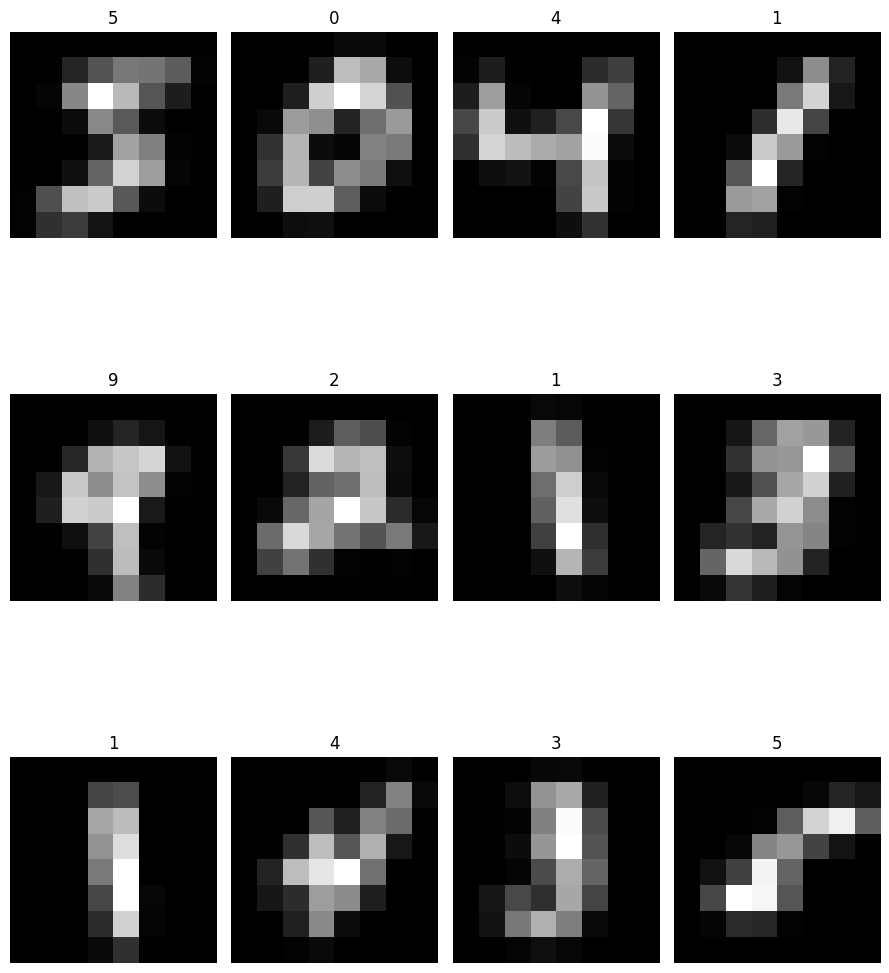

In [25]:
# Assuming each image has shape (C,W,H)=(1, 8, 8)
images, labels = zip(*[train_dataset[i] for i in range(12)])

fig, axes = plt.subplots(3, 4, figsize=(9, 12))
for i, ax in enumerate(axes.flat):
    img = images[i].squeeze(0) # Remove the channel dimension (1,) -> (8, 8)
    ax.imshow(img, cmap='gray')
    ax.set_title(str(labels[i]), fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Step 2: Model development (CNN)

We create a CNN from scratch with `torch.nn.Conv2d` (https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). First, we'll define a function with the basic parameters we'll use in each convolution. Each layer receives `ic` channels of input and produces `oc` output channels.

The input of the CNN has shape (N,C,W,H) where N is the batch size, C is the number of input channels, W and H are the width and height of each image. The image size of the input and output of a single convolutional layer are in general different (the output size in this case is half of the input size), but it depends on the parameters of the convolution.

In [26]:
# Convolutional block with batch normalization: ic=input channels; oc=output channels
def conv(ic, oc, act=True):
    ks = 3
    layers = [
        nn.Conv2d(ic, oc, stride=2, kernel_size=ks, padding=ks//2),
        nn.BatchNorm2d(oc)  # insert nn.BatchNorm2d layer after each convolution and before the activation (ReLU).
    ]
    return nn.Sequential(*layers)

# Build the CNN model with layers of conv(ic,oc) and Dropout
ks = 3
simple_cnn = nn.Sequential(
    conv(1, 8),              # convolution and batchnorm; Output: 4x4
    nn.Dropout2d(p=0.25),    # Add 2D Dropout after the first conv layer (common for CNNs)
    nn.ReLU(),               # activation layer
    conv(8, 16),             # Output: 2x2
    nn.Dropout2d(p=0.25),    # Add 2D Dropout after the second conv layer
    nn.ReLU(),               # activation layer
    conv(16, 10, act=False), # Output: 1x1
    nn.Flatten(), # Use the predefined nn.Flatten layer
    # You could also add a standard nn.Dropout here if you had a fully connected layer after Flatten,
    # but in this specific architecture, Flatten is followed directly by the output layer.
)
# Example usage with a dummy input
xb = torch.randn(64, 1, 8, 8)  # (N,C,W,H): batch size 64, 1 channel, 8*8 image
output = simple_cnn(xb)
print(output.shape)  # torch.Size([64, 10])

torch.Size([64, 10])


In [27]:
from torchsummary import summary
# Move the model to the selected device before summarizing
simple_cnn.to(device)
# For your model, input size is (1, 8, 8) (channels, height, width)
summary(simple_cnn, input_size=(1, 8, 8), device=str(device))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 8, 4, 4]              80
       BatchNorm2d-2              [-1, 8, 4, 4]              16
         Dropout2d-3              [-1, 8, 4, 4]               0
              ReLU-4              [-1, 8, 4, 4]               0
            Conv2d-5             [-1, 16, 2, 2]           1,168
       BatchNorm2d-6             [-1, 16, 2, 2]              32
         Dropout2d-7             [-1, 16, 2, 2]               0
              ReLU-8             [-1, 16, 2, 2]               0
            Conv2d-9             [-1, 10, 1, 1]           1,450
      BatchNorm2d-10             [-1, 10, 1, 1]              20
          Flatten-11                   [-1, 10]               0
Total params: 2,766
Trainable params: 2,766
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

## Step 3: Model training (and saving model)

This function `compute_accuracy` is not necessary for training. It will be used to keep track of the accuracy for each batch of examples and used to estimate accuracy after each epoch, both for training and for validation data sets.

In [28]:
# Computes the accuracy for a batch: outputs are probability-like values
def compute_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    total = len(labels)
    return correct / total

### Training

This is the main train look in PyTorch. Note that a few extra functionalities were added to keep track of estimated accuracies.

A the end of each epoch, the model is saved into a file. In general, this is not done for large models but it allow us to re-use later each trained model for any epoch.

In [29]:
num_epochs = 10
model = simple_cnn

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.to(device) #<<<<<<<<<< move model to device

# History object to keep track of accuracy along epochs
history = {'epoch': [], 'train_accuracy': [], 'val_accuracy': []}

for epoch in range(num_epochs):
    print(f'epoch: {epoch+1}; time: {round(time.time())}')
    model.train()
    batch_accuracies=[] # to store estimated accuracy for each batch
    # loop through batches of examples
    for images, labels in train_loader:
        images = images.to(device)  #<<<<<<<<<< move data to device
        labels = labels.to(device)  #<<<<<<<<<< move data to device
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # compute accuracy over the batch
        batch_accuracies.append(compute_accuracy(outputs, labels))
    history['epoch'].append(epoch+1)
    history['train_accuracy'].append(sum(batch_accuracies) / len(batch_accuracies))
    print(f'epoch: {epoch+1}; accuracy: {sum(batch_accuracies) / len(batch_accuracies)}')
    # save current model before next epoch
    model_filename=f'simple_cnn_epoch_{epoch+1}.pth'
    torch.save(model, model_filename)

epoch: 1; time: 1748432012
epoch: 1; accuracy: 0.7219316364605544
epoch: 2; time: 1748432024
epoch: 2; accuracy: 0.828141657782516
epoch: 3; time: 1748432035
epoch: 3; accuracy: 0.8412180170575693
epoch: 4; time: 1748432047
epoch: 4; accuracy: 0.8500466417910447
epoch: 5; time: 1748432058
epoch: 5; accuracy: 0.8566764392324094
epoch: 6; time: 1748432069
epoch: 6; accuracy: 0.8576259328358209
epoch: 7; time: 1748432081
epoch: 7; accuracy: 0.8608742004264393
epoch: 8; time: 1748432092
epoch: 8; accuracy: 0.8627898454157783
epoch: 9; time: 1748432103
epoch: 9; accuracy: 0.8661380597014925
epoch: 10; time: 1748432114
epoch: 10; accuracy: 0.8678871268656716


## Step 4: Validation (and loading model)

Validation is important for several goals, including:
- to estimate the accuracy of the model for the task at hand;
- to determine the optimal number of iterations (epochs);
- to be able to tune the model choosing the best hyperparameters.

Below, we will concentrate on the first two of those issues, and we will compare the estimated overall accuracy over the train and the test sets. In order to do this need to keep track of the intermediate results for each epoch and each batch of examples.

### Loading model and compute predictions for the validation data set

In [30]:
for epoch in range(num_epochs):
    print(f'epoch: {epoch+1}; time: {round(time.time())}')
    # load model
    model_filename=f'simple_cnn_epoch_{epoch+1}.pth'
    model=torch.load(model_filename, weights_only=False) # by default, only weights are loaded, and the architecture of the network must be known
    model.to(device) #<<<<<<<<<< move model to device
    # Validation phase
    model.eval()
    batch_accuracies=[]
    with torch.no_grad():
        # loop through batches of examples
        for images, labels in test_loader:
            images = images.to(device)  #<<<<<<<<<< move data to device
            labels = labels.to(device)  #<<<<<<<<<< move data to device
            outputs = model(images)
            # compute accuracy over the batch
            batch_accuracies.append(compute_accuracy(outputs, labels))
        history['val_accuracy'].append(sum(batch_accuracies) / len(batch_accuracies))
        print(f'epoch: {epoch+1}; accuracy: {sum(batch_accuracies) / len(batch_accuracies)}')


epoch: 1; time: 1748432125
epoch: 1; accuracy: 0.9046576433121019
epoch: 2; time: 1748432127
epoch: 2; accuracy: 0.9166998407643312
epoch: 3; time: 1748432128
epoch: 3; accuracy: 0.9265525477707006
epoch: 4; time: 1748432130
epoch: 4; accuracy: 0.9312300955414012
epoch: 5; time: 1748432131
epoch: 5; accuracy: 0.9317277070063694
epoch: 6; time: 1748432132
epoch: 6; accuracy: 0.9339171974522293
epoch: 7; time: 1748432134
epoch: 7; accuracy: 0.933718152866242
epoch: 8; time: 1748432135
epoch: 8; accuracy: 0.9382961783439491
epoch: 9; time: 1748432137
epoch: 9; accuracy: 0.9362062101910829
epoch: 10; time: 1748432138
epoch: 10; accuracy: 0.9378980891719745


### Plot training and validation estimated accuracies

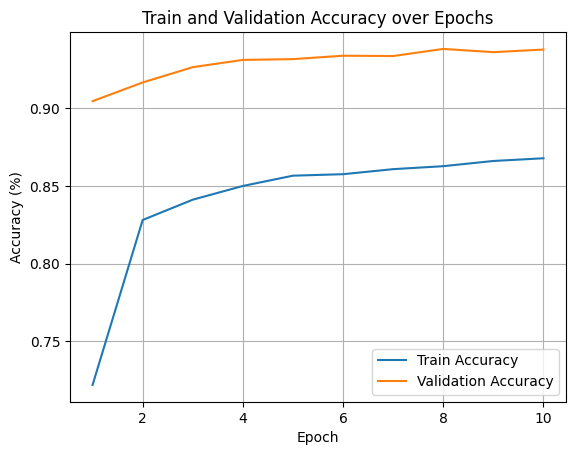

In [31]:
# accuracy plot
plt.plot(history['epoch'], history['train_accuracy'], label='Train Accuracy')
plt.plot(history['epoch'], history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()